# Contents

1. [Data Wrangling](#1.-Data-Wrangling)  
    1.1. [Data reading](#1.1.-Data-reading)  
    1.2. [Data cleaning](#1.2.-Data-cleaning)  
    1.3. [Filtering for politicians](#1.3.-Filtering-for-politicians)  
    1.4. [Interlude - Does our assumption make sense?](#1.4.-Interlude---Does-our-assumption-make-sense?)  
    1.5. [Extract domains](#1.5.-Extract-domains)  
    1.6. [Saving data](#1.6.-Saving-data)  
    1.7. [Scaling up](#1.7.-Scaling-up)

# **1. Data Wrangling**

To deal with the size of Quotebank we decided to build our pipeline on top of Apache Spark, the de-facto standard framework for big data processing. 

With respect to Pandas, which is single-threaded, Spark is inherently **multi-threaded** and can allow for a better use of all the cores of the machine. Moreover, instead of trying to fit all the data in the local RAM, Spark split up by default the data into small chunks, which are processed independently and can be temporarly **stored on disk** [[1]](https://towardsdatascience.com/spark-vs-pandas-part-2-spark-c57f8ea3a781). Finally, Spark uses a _lazy execution_ model, processing the data not when an operation is applied but only when the result is required, optimizing the steps in the meanwhile.

In particular, we will use the recently added support for **pandas API** (pyspark.pandas, needs `pyspark==3.2.0`), which allow to take advantage of Spark scalability with the familiar syntax of pandas. 

In [1]:
!pip install pyspark
!pip install pyspark[pandas_on_spark] plotly

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
# Requirement to import pyspark.pandas - setting env variable PYARROW_IGNORE_TIMEZONE to 1
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark.pandas as ps

In [4]:
# Should make these generic also to someone who does not have access to our ADA folder
quotebank_folder = '/content/drive/MyDrive/ADA/Quotebank/'
dataset_folder = '/content/drive/MyDrive/ADA/Project datasets/'
preprocess_folder = '/content/drive/MyDrive/ADA/Processed/'
wikidata_speakers = os.path.join(dataset_folder, 'speaker_attributes.parquet')
wikidata_labels = os.path.join(dataset_folder, 'wikidata_labels_descriptions_quotebank.csv.bz2')

## 1.1. Data reading

To test and showcase our preprocessing pipeline, we will use only a small sample of the data and show the result of each step with Pandas. Then, to fully exploit the _lazy execution_ paradigm, we will apply all the operations on the full dataset without showing the partial results, so that Spark can optimize the execution plan under the hood.

In [5]:
filepath = os.path.join(quotebank_folder, 'quotes-2020.json.bz2')
samplepath = os.path.join(preprocess_folder, 'quotes-2020-sample.json.bz2')

In [6]:
# Create a sample from 2020 quotes, if it does not already exists
if(not os.path.exists(samplepath)):
  df = ps.read_json(filepath, compression='bzip2')
  df_short = df.sample(frac=(100000 / 5244449))
  df_short.to_json(samplepath, compression='bzip2')

df_short = ps.read_json(samplepath, compression='bzip2').to_pandas()

In [7]:
len(df_short)

99561

## 1.2. Data cleaning

In [8]:
# Drop rows with the same quoteID, keeping only the first in case of duplicates
len_before = len(df_short)
df_short = df_short.drop_duplicates(subset='quoteID', keep='first')
len_after = len(df_short)
print(f'Removed {len_before - len_after} duplicates')

Removed 0 duplicates


In [9]:
# Drop unused columns
df_short = df_short.drop(['numOccurrences', 'phase', 'probas', 'quoteID'], axis=1)

In [10]:
# Drop nans in quotations or speaker
len_before = len(df_short)
df_short = df_short.dropna(subset=['quotation', 'speaker'])
len_after = len(df_short)
print(f'Removed {len_before - len_after} rows containing nans')

Removed 0 rows containing nans


In [11]:
# Keep only rows with an identified speaker
len_before = len(df_short)
df_short = df_short[df_short.speaker != 'None']
len_after = len(df_short)
print(f'Removed {len_before - len_after} rows without speaker')

Removed 34104 rows without speaker


In [12]:
# Reset index
df_short.reset_index(drop=True, inplace=True)

In [13]:
# Print length after cleaning
len(df_short)

65457

In [14]:
df_short

,date,qids,quotation,speaker,urls
0,2020-02-16 13:00:00,"[Q1286476, Q21285393, Q7436904, Q7436906, Q743...",Now they are leaving it behind.,Scott Morrison,[https://www.coffscoastadvocate.com.au/news/i-...
1,2020-02-10 13:21:52,[Q44430],OOOOOOHHHH YEAAAAHHH BOY LET'S GOOO!!,Vince McMahon,[http://bringmethenews.com/minnesota-sports/wi...
2,2020-03-31 23:03:15,"[Q1277017, Q19665390, Q21458602, Q41053943, Q4...",Our people are our priority during this diffic...,Michael Anderson,[http://nzherald.co.nz/business/news/article.c...
3,2020-01-14 02:09:00,[Q22277803],She got her film seen and people are recognisi...,Florence Pugh,[http://www.asiaone.com/entertainment/its-most...
4,2020-02-06 19:46:42,[Q40504],She has a gift. When she opens her mouth and s...,Jim Carrey,[https://www.bostonherald.com/2020/02/06/jim-c...
...,...,...,...,...,...
65452,2020-02-12 04:47:52,"[Q3973213, Q7613555, Q7613556]",We all want this stuff gone and one of the mis...,Steve Parry,[http://radionz.co.nz/news/national/409387/gor...
65453,2020-02-04 11:30:00,"[Q3163230, Q6166609]",We are proud to announce the formation of the ...,Jay Ferguson,[https://forextv.com/top-news/vicente-capital-...
65454,2020-02-27 19:42:52,[Q7367220],We will be introducing a breakfast sandwich th...,Rosalind Brewer,[https://www.foodbusinessnews.net/articles/155...
65455,2020-02-17 03:46:38,[Q3431531],We've played a lot of road games this month ea...,Rick Bowness,[http://sportsday.dallasnews.com/sports/stars/...


## 1.3. Filtering for politicians

In a first phase, we are only interested in considering the quotes of US politicians, to extract the most meaningful topics with respect to modern political debate. To do so, we will use information about speakers retrieved from Wikidata dumps. 

In [15]:
df_speakers = ps.read_parquet(wikidata_speakers)

In [16]:
len(df_speakers)

9055981

In [17]:
df_speakers.columns

Index(['aliases', 'date_of_birth', 'nationality', 'gender', 'lastrevid',
       'ethnic_group', 'US_congress_bio_ID', 'occupation', 'party',
       'academic_degree', 'id', 'label', 'candidacy', 'type', 'religion'],
      dtype='object')

The occupation of politician corresponds on Wikidata to the Qid [`Q82955`](https://www.wikidata.org/wiki/Q82955), and the US country Qid is [`Q30`](https://www.wikidata.org/wiki/Q30). Also, to keep the quotes relevant to modern political debate, we will only consider politicians born after 1920.

In [18]:
# Set id as index
df_speakers.set_index('id', inplace=True)

# Drop all columns but occupation, nationality and date_of_birth, the only ones necessary to identify modern US politicians
df_speakers_politicians = df_speakers.drop(df_speakers.columns.difference(['occupation', 'nationality', 'date_of_birth']), axis=1)

# Drop all rows without an occupation, a country of citizenship or a date_of_birth
df_speakers_politicians = df_speakers_politicians.dropna(subset=['occupation', 'nationality', 'date_of_birth'])

# Apply masking.
occupations_mask = df_speakers_politicians.occupation.apply(lambda x: 'Q82955' in x)
nationality_mask = df_speakers_politicians.nationality.apply(lambda x: 'Q30' in x)
birth_mask = df_speakers_politicians.date_of_birth.apply(lambda x: int(x[0][1:].split('-', 1)[0]) > 1920)
mask = occupations_mask & nationality_mask & birth_mask
df_speakers_politicians = df_speakers_politicians[mask]

In [19]:
# Get Qids of politicians (~1min)
politicians_ids = df_speakers_politicians.index.to_numpy()

In [20]:
politicians_ids.size

21715

We can now extract from our Quotebank sample only quotes from politicians. \\
In general, it is not always possible to assign to each speaker a unique Qid, because different homonyms might exists. In this context, since we are considering only quotes from news articles, the most likely occupation of speakers is politician. Thus, when the Qid is not uniquely assigned, **we will assume that the correct assignement is the Qid corresponding to a politician**, if exists. Rows where more than one Qids correspond to politicians will instead be dropped, because there is no easy way to establish which speaker is the correct one.

In [21]:
# Return Qid if among the identified people there is exactly one politician
def intersect_politicians(x):
  intersection = set(x).intersection(politicians_ids)
  if(len(intersection) != 1):
    return None
  return list(intersection)[0]

In [22]:
# Create DataFrame of politicians only, selecting qids as explained and dropping other rows
df_short_politicians = df_short.copy()
df_short_politicians.qids = df_short_politicians.qids.apply(intersect_politicians)

In [23]:
df_short_politicians = df_short_politicians[df_short_politicians.qids.notna()]
df_short_politicians.reset_index(drop=True, inplace=True)

In [24]:
df_short_politicians

,date,qids,quotation,speaker,urls
0,2020-01-23 22:29:35,Q7687964,Correctional officers received higher pay over...,Tate Reeves,[https://yallpolitics.com/2020/01/23/governor-...
1,2020-02-26 22:53:36,Q22686,Prime Minister Modi and President Trump commit...,President Donald Trump,[https://www.newkerala.com/news/2020/31253.htm]
2,2020-03-16 19:17:22,Q13562456,The forces of the status quo have been effecti...,Nina Turner,[http://p.washingtontimes.com/news/2020/mar/16...
3,2020-02-09 18:22:09,Q22686,The Trump administration has reversed almost a...,Donald Trump,[https://www.alternet.org/2020/02/white-house-...
4,2020-02-10 00:00:00,Q359442,You cannot take support to billionaires and th...,Bernie Sanders,[https://thiscantbehappening.net/the-red-baiti...
...,...,...,...,...,...
9094,2020-03-18 17:31:36,Q11673,That 50% can be calibrated.,Andrew Cuomo,[https://kticradio.com/abc_national/coronaviru...
9095,2020-03-15 23:03:39,Q4766748,"Those of us that do this, and I don't care wha...",Ann Williams,[https://abc17news.com/news/national-world/202...
9096,2020-03-17 19:56:00,Q6262874,We can email Murphy's SuperValu in Castletownb...,John Walsh,[http://feeds.breakingnews.ie/~r/bnireland/~3/...
9097,2020-01-15 01:34:53,Q22686,America is the envy of the entire world,President Donald Trump,[https://www.townsvillebulletin.com.au/news/wo...


## 1.4. Interlude - Does our assumption make sense?


To test if our assumption make sense we will analyze the distribution of occupations amongst speakers who correspond to uniquely identified qids, in order to investigate if politician is indeed the most popular occupation.

In [25]:
# Only consider quotes with a uniquely identify qid
df_short_unique = df_short[df_short.qids.apply(lambda x: len(x)) == 1]

In [26]:
# Get dictionary of {person: occupations}
occupations_dict = df_speakers.occupation.dropna().to_dict()

In [27]:
# Count the occurrencies of each occupation
from collections import Counter
counter = Counter()
for qid in df_short_unique.qids:
  try:
    occupations = occupations_dict[qid[0]]
  except KeyError:
    continue
  if(occupations):
    for occupation in occupations:
      counter[occupation] += 1

In [28]:
# Sort the Counter
counter = counter.most_common()

In [29]:
counter[:10]

[('Q82955', 14435),
 ('Q33999', 5676),
 ('Q36180', 4302),
 ('Q40348', 4052),
 ('Q10800557', 3262),
 ('Q43845', 3203),
 ('Q10798782', 2981),
 ('Q937857', 2672),
 ('Q1930187', 2560),
 ('Q3282637', 2484)]

To get a clearer interpretation, we need to remap the qids of occupation with their textual label. Also, since each person can have multiple occupations, we will divide the occurrence of each occupation by the total number of people (the number of rows of the considered database), to analyze which share each occupation has in the sample.

In [30]:
# Get dictionary of {occupation qid: label}
labels = pd.read_csv(wikidata_labels, compression='bz2')
labels.set_index('QID', inplace=True)

In [31]:
# Extract list of qids and occurrencies and convert them to np.array
qids, occurrencies = list(zip(*counter))
qids = np.array(qids)
occurrencies = np.array(occurrencies)

In [32]:
# Remap qids to labels and keep only the first N_POP entries, dividing the occurrencies by the number of people.
N_POP = 12
labels_popular = labels.loc[qids[:N_POP+1]].Label.values
occurrencies_popular = occurrencies[:N_POP+1]  / len(df_short_unique)

In [33]:
labels_popular

array(['politician', 'actor', 'writer', 'lawyer', 'film actor',
       'businessperson', 'television actor',
       'association football player', 'journalist', 'film producer',
       'television producer', 'singer', 'television presenter'],
      dtype=object)

In [34]:
occurrencies_popular

array([0.3025698 , 0.11897376, 0.09017356, 0.08493334, 0.06837428,
       0.06713759, 0.06248428, 0.05600738, 0.05365976, 0.05206674,
       0.04948856, 0.04829379, 0.04317934])

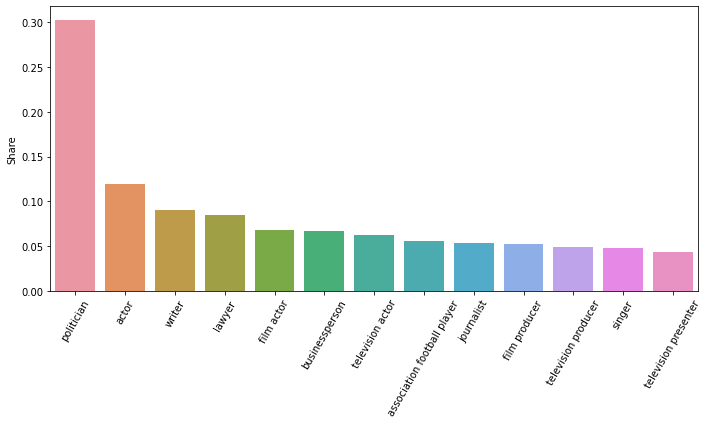

In [35]:
fig = plt.figure(figsize=(10, 6))
sns.barplot(x=labels_popular, y=occurrencies_popular)
plt.ylabel('Share')
plt.xticks(rotation=60)
plt.tight_layout()

Note, again, that despite being called "shares" this categories do not partition the population, because each person can have multiple occupations.
The plot shows that politician is by far the most popular occupation, and approximately **30% of speakers in the database are politicians**. Thus, this reasonably justify our working assumption.

## 1.5. Extract domains

Since later we will also be interested in placing newspapers on our Political Compass to investigate for news biases, we need to extract for each quote the domain(s) of the url(s), corresponding to the source of the original articles.

In [36]:
from urllib.parse import urlparse

def urls_to_domains(url_list):
  '''
  extract a list of domains from a list of urls
  '''
  parsed_urls = [urlparse(x) for x in url_list]
  # Remove leading www. and use list(set()) for deduplication
  return list(set([x.netloc[4:] if x.netloc[:4] == 'www.' else x.netloc for x in parsed_urls if x and x.netloc]))

In [37]:
df_short_politicians['domains'] = df_short_politicians['urls'].apply(urls_to_domains)
df_short_politicians

,date,qids,quotation,speaker,urls,domains
0,2020-01-23 22:29:35,Q7687964,Correctional officers received higher pay over...,Tate Reeves,[https://yallpolitics.com/2020/01/23/governor-...,[yallpolitics.com]
1,2020-02-26 22:53:36,Q22686,Prime Minister Modi and President Trump commit...,President Donald Trump,[https://www.newkerala.com/news/2020/31253.htm],[newkerala.com]
2,2020-03-16 19:17:22,Q13562456,The forces of the status quo have been effecti...,Nina Turner,[http://p.washingtontimes.com/news/2020/mar/16...,"[p.washingtontimes.com, washingtontimes.com]"
3,2020-02-09 18:22:09,Q22686,The Trump administration has reversed almost a...,Donald Trump,[https://www.alternet.org/2020/02/white-house-...,[alternet.org]
4,2020-02-10 00:00:00,Q359442,You cannot take support to billionaires and th...,Bernie Sanders,[https://thiscantbehappening.net/the-red-baiti...,"[counterpunch.org, thiscantbehappening.net]"
...,...,...,...,...,...,...
9094,2020-03-18 17:31:36,Q11673,That 50% can be calibrated.,Andrew Cuomo,[https://kticradio.com/abc_national/coronaviru...,"[kticradio.com, wimsradio.com]"
9095,2020-03-15 23:03:39,Q4766748,"Those of us that do this, and I don't care wha...",Ann Williams,[https://abc17news.com/news/national-world/202...,"[abc17news.com, localnews8.com]"
9096,2020-03-17 19:56:00,Q6262874,We can email Murphy's SuperValu in Castletownb...,John Walsh,[http://feeds.breakingnews.ie/~r/bnireland/~3/...,[feeds.breakingnews.ie]
9097,2020-01-15 01:34:53,Q22686,America is the envy of the entire world,President Donald Trump,[https://www.townsvillebulletin.com.au/news/wo...,[townsvillebulletin.com.au]


## 1.6. Saving data

To reuse our processed sample to explore tools for Topic Extraction and Sentiment Analysis, we will save the database as a parquet file.

In [38]:
samplepath_processed = os.path.join(preprocess_folder, 'quotes-2020-sample.parquet.gzip')

In [39]:
df_short_politicians.to_parquet(samplepath_processed, compression='gzip')

## 1.7. Scaling up

In [40]:
def preprocess_politicians(df):
  '''
  Preprocess the dataframe df and extract only quotes from modern US politicians 
  '''
  # Drop duplicates
  df.drop_duplicates(subset='quoteID', keep='first', inplace=True)

  # Drop unused columns
  df = df.drop(['numOccurrences', 'phase', 'probas', 'quoteID'], axis=1)

  # Drop nans
  df.dropna(subset=['quotation', 'speaker'], inplace=True)

  # Reset index
  df.reset_index(drop=True, inplace=True)

  # Match qids to politicians
  df_politicians = df.copy()
  df_politicians.qids = df_politicians.qids.apply(intersect_politicians)

  # Filter for modern US politicians
  df_politicians = df_politicians[df_politicians.qids.notna()]
  df_politicians.reset_index(drop=True, inplace=True)

  # Extract domains
  df_politicians['domains'] = df_politicians['urls'].apply(urls_to_domains)

  return df_politicians

Let's now apply our pipeline to the entire Quotebank database (phase E).

In [ ]:
for filename in os.listdir(quotebank_folder)[0:2]:
  filepath = os.path.join(quotebank_folder, filename)
  processpath = os.path.join(preprocess_folder, filename.split('.')[0] + '.parquet.gzip')
  if(not os.path.exists(processpath)):
    print(f'Reading {filepath}...')
    df = ps.read_json(filepath, compression='bzip2')
    print(f'Reading {filepath} done')
    print(f'Processing {filepath}...')
    df_politicians = preprocess_politicians(df)
    df_politicians.to_parquet(processpath, compression='gzip')
    print(f'Processing {filepath} done')
  else:
    print(f'Found {processpath}')

To test that everything went well, we will now load both the original and the parquet files for a year different than 2020 (the one from which we sampled our test dataset), and print the number of rows before and after the processing stage. We expect the filter to select a similar proportion of rows with respect to the sample that we used to showcase our pipeline in the previous sections, i.e. somewhat around the 9% of entries

In [42]:
filename = os.path.join(quotebank_folder, 'quotes-2016.json.bz2')
processname = os.path.join(preprocess_folder, 'quotes-2016.parquet.gzip')
print('Reading ' + filename.split('.')[0] + '...')
df = ps.read_json(filename, compression='bzip2')
print('Reading ' + processname.split('.')[0] + '...')
df_politicians = ps.read_parquet(processname, compression='gzip')
len_before = len(df)
len_after = len(df_politicians)
print(f'Rows before processing: {len_before}')
print(f'Rows after processing: {len_after}')
print(f'Percentage of filtered rows: {(len_after / len_before * 100):.2f}%')
print('----------------------------------')

Reading /content/drive/MyDrive/ADA/Quotebank/quotes-2016...
Reading /content/drive/MyDrive/ADA/Processed/quotes-2016...
Rows before processing: 13862129
Rows after processing: 1117573
Percentage of filtered rows: 8.06%
----------------------------------


Indeed, our wrangling pipeline seems to be working smoothly.